In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

pallete = sns.cubehelix_palette(start=0.7, rot=-0.4, dark=0.2, light=1.0, as_cmap=True, reverse=True)
alphabet = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', \
            'G', 'H', 'I', 'L', 'K', 'M', 'F', \
            'P', 'S', 'T', 'W', 'Y', 'V']

RANGE_RESTRAINTS = 5
DISTANCE_THRESHOLD = 8.

Some helper functions 

In [2]:
# get index of a particular value in DataFrame
def get_index(fm, value):
    row = []
    col = []
    for i in range(fm.shape[0]):
        for j in range(fm.shape[1]):
            if fm.iloc[i, j] == value:    
                row.append(i)
                col.append(j)
    return zip(row, col)

In [3]:
# draw a heatmap
def heatmap(mat):
    sns.heatmap(mat, linecolor='black', linewidths=0.01, annot=False, cmap=pallete)

### 1. Preprocess

Load the data table for further processing

In [4]:
table = pd.DataFrame(pd.read_table('structure.txt', sep='\t'))

Get parts of the table with CDR3 region for each of the chain (alpha/beta)

In [5]:
alpha_CDR3_filter = (table['tcr_region'] == 'CDR3') & (table['tcr_v_allele'].str.startswith('TRA'))
beta_CDR3_filter = (table['tcr_region'] == 'CDR3') & (table['tcr_v_allele'].str.startswith('TRB'))
grouped_alpha = table[alpha_CDR3_filter].groupby('pdb_id')
grouped_beta = table[beta_CDR3_filter].groupby('pdb_id')

pnames = grouped_alpha.groups.keys()

### 2. Energy/distance correlation (just for fun)


Lets plot the correlation between interaction energy of amino acid pair and the distance between amino acids in this pair. For that we norm the distance values for each complex so that the maximum value over the complex corresponds to 1.0. Energy is normed in the same way, except for that we make all the values positive, because we want to evaluate the strength of the interaction.
- - -

In [6]:
n_d = {x: max(grouped_alpha.get_group(x)['distance']) for x in grouped_alpha.groups.keys()}
n_e = {x: max(map(np.abs, grouped_alpha.get_group(x)['energy'])) for x in grouped_alpha.groups.keys()}
bufer = table[alpha_CDR3_filter].drop(table[alpha_CDR3_filter].columns[1:-2], axis=1)
for key in pnames:
    fil = bufer['pdb_id'] == key
    bufer.loc[fil, 'distance'] = map(np.abs, [x/n_d[key] for x in bufer[fil]['distance']])
    bufer.loc[fil, 'energy']   = map(np.abs, [x/n_e[key] for x in bufer[fil]['energy']])

Plot the result for alpha chain

/home/mikhail/Development/Libs/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


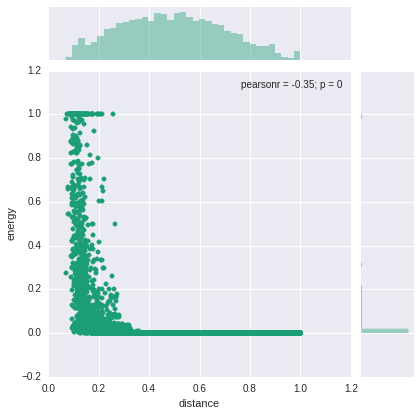

In [7]:
# Energy/distance correlation for each aa pair in CDR3alpha/antigen interaction
#
#marginal_kws=dict(name='Energy/distance correlation for each aa pair')
sns.set_style("darkgrid");
sns.jointplot(x='distance', y='energy', data=bufer);

### Total interaction energy of CDR3/antigen

Its interesting to plot distribution of total interaction energy of CDR3 region with antigen for alpha and beta chain separately, and then in combination to estimate possible energy values.
- - -

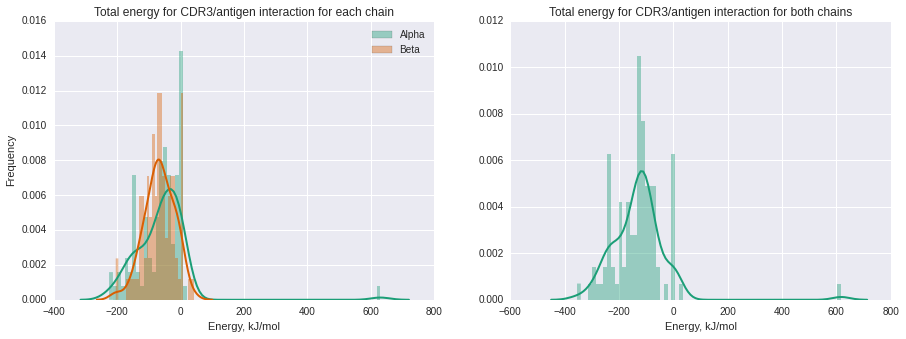

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.distplot(grouped_alpha['energy'].agg(sum), bins=70, label='Alpha')
sns.distplot(grouped_beta['energy'].agg(sum), bins=30, label='Beta')
plt.legend(loc='best')
plt.xlabel("Energy, kJ/mol")
plt.ylabel("Frequency")
plt.title("Total energy for CDR3/antigen interaction for each chain")

plt.subplot(122)
sns.distplot(grouped_alpha['energy'].agg(sum) + grouped_beta['energy'].agg(sum), bins=70, label='Alpha + Beta')
plt.title("Total energy for CDR3/antigen interaction for both chains")
plt.xlabel("Energy, kJ/mol");

### 4. Preferences in amino acid position 

First define some helper functions

In [9]:
# get square matrix for CDR3 and Antigen amino acids
# fm - data frame; ex.: gr.get_group('1ao7')
# col - either 'distance' or 'energy'
def get_matrix(fm, col):
    group = fm.reset_index()
    lenantigen = group.loc[0,'len_antigen']
    lentcr = group.loc[0,'len_tcr']

    mat = group.pivot('pos_antigen', 'pos_tcr', col)
    #hmap.columns = pd.MultiIndex.from_tuples(zip(range(lentcr), group['aa_tcr'][::lenantigen]))#
    mat.columns = group['aa_tcr'][::lenantigen]
    #hmap.index = pd.MultiIndex.from_tuples(zip(range(lenantigen), group['aa_antigen'][:lenantigen]))
    mat.index = group['aa_antigen'][:lenantigen]
    return mat

In [12]:
# not used at the moment
'''hmap = get_matrix(grouped_alpha.get_group('1ao7'), 'distance')

min_loc = get_index(hmap, hmap.min().min()) 

min_borders = [[min_loc[0][0] - RANGE_RESTRAINTS, min_loc[0][0] + RANGE_RESTRAINTS + 1], \
               [min_loc[0][1] - RANGE_RESTRAINTS, min_loc[0][1] + RANGE_RESTRAINTS + 1]]
if min_borders[0][0] < 0:
    min_borders[0][0] = 0
if min_borders[1][0] < 0:
    min_borders[1][0] = 0
if min_borders[0][1] > hmap.shape[0]:
    min_borders[0][1] = hmap.shape[0]
if min_borders[1][1] > hmap.shape[1]:
    min_borders[1][1] = hmap.shape[1]'''
    
# get centered aa position
def rel_pos(fm, loc):
    return [loc[0] - fm.shape[0]/2, loc[1] - fm.shape[1]/2]

Now estimate the disribution of the position of the most interacting antigen amino acid. The process is as following: 
1. get the minimum pairwise distance for a particular complex
2. define the position of the antigen amino acid participating in this pair (0 is in the centre of the antigen)
3. collect the list of these positions for each TCR chain (alpha/beta)
- - -

In [15]:
# get a list of most interacting antigen aa position for each complex
def get_list_of_closest_aa_positions(grouped, flag):
    empty = []
    for name in pnames:
        min_dist = grouped.get_group(name)[flag].min()
        m = get_matrix(grouped.get_group(name), flag)
        empty.append(rel_pos(m, get_index(m, min_dist)[0])[0])
    return empty

# Desirable lists
antigen_closest_pos_alpha_list = get_list_of_closest_aa_positions(grouped_alpha, 'distance')
antigen_closest_pos_beta_list = get_list_of_closest_aa_positions(grouped_beta, 'distance')

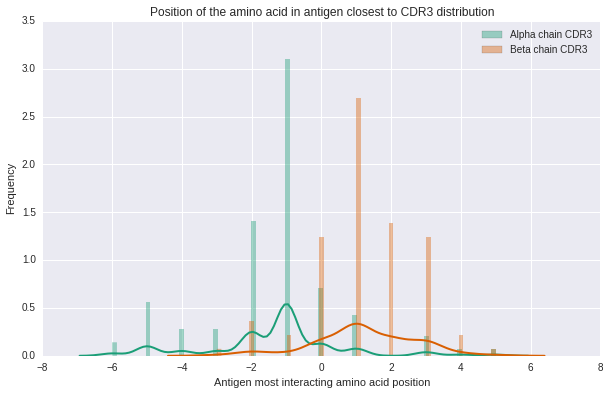

In [16]:
sns.set_style("darkgrid")
sns.distplot(antigen_closest_pos_alpha_list, bins=80, label='Alpha chain CDR3')
sns.distplot(antigen_closest_pos_beta_list, bins=60, label='Beta chain CDR3')
plt.xlabel('Antigen most interacting amino acid position')
plt.ylabel('Frequency')
plt.title('Position of the amino acid in antigen closest to CDR3 distribution')
plt.legend();

### Amino acid interaction matrices

Some helper functions which allow to complete amino acid table if some of amino acids are absent

In [30]:
# fill rows and columns in aa interaction matrix 
# with NaNs for those aas, which are not encoutered in tcr or antigen
def add_lacking_rows_and_columns(matrix):
    for column in list(set(alphabet).difference(set(matrix.columns))):
        matrix.loc[:, column] = np.nan
    matrix.sort_index(axis=1, inplace=True)
    for row in list(set(alphabet).difference(set(matrix.index))):
        matrix.loc[row, :] = np.nan
    matrix.sort_index(axis=0, inplace=True, ascending=False)
    return matrix

def add_lacking_rows(matrix):
    for row in list(set(alphabet).difference(set(matrix.index))):
        matrix.loc[row, :] = np.nan
    matrix.sort_index(axis=0, inplace=True, ascending=False)
    return matrix

Here the series of all the pairs of amino acids which were encoutered in the complexes is produced in such way that indices of the series - are pairs of the amino acid names, and the values - are True/False which reflect interaction (depending of the distance threshold). Series are produced separately for each chain.

In [24]:
# list of series with pairwise aa distances for each complex
ser_list = [(get_matrix(grouped_alpha.get_group(name), 'distance') < DISTANCE_THRESHOLD).stack() for name in pnames]
ser_all_alpha = pd.concat(ser_list)
ser_list = [(get_matrix(grouped_beta.get_group(name), 'distance') < DISTANCE_THRESHOLD).stack() for name in pnames]
ser_all_beta = pd.concat(ser_list)

This function summarises those cases in which interaction was detected for each possible pair of amino acids, using DISTANCE_THRESHOLD variable, and creates square amino acid matrix, which cells contain number of interacting pairs

In [33]:
def aa_interaction_matrix_unnormed(series):
    # group by unique pairs of aa
    aa_pairs_series = series.groupby(level=[0, 1]).sum()
    aa_pairs_matrix = aa_pairs_series.unstack(level=1)
    # fill lacking rows and columns with NaNs
    aa_pairs_matrix = add_lacking_rows_and_columns(aa_pairs_matrix)
    return aa_pairs_matrix

Plotting (black cells stand for NaN)

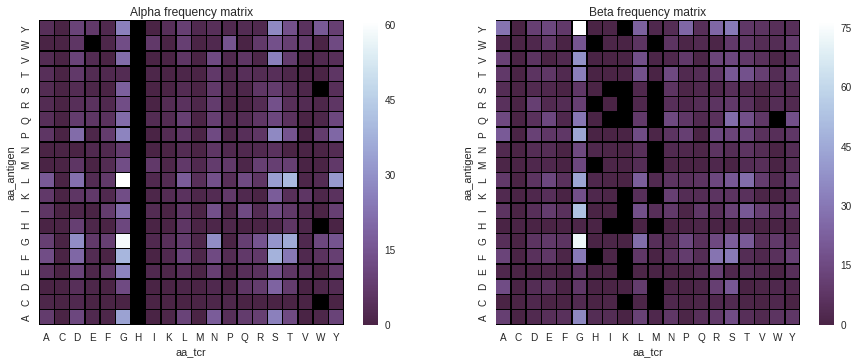

In [34]:
sns.set(rc={'axes.facecolor':'black'})  
plt.figure(figsize=(15,12))

plt.subplot(221)
heatmap(aa_interaction_matrix_unnormed(ser_all_alpha))
plt.title('Alpha frequency matrix')

plt.subplot(222)
heatmap(aa_interaction_matrix_unnormed(ser_all_beta))
plt.title('Beta frequency matrix')

sns.set(rc={'axes.facecolor':'white'})

To get the real interaction matrix normalization should be used. Here the norming matrix is produced and imposed on the frequency matrices. Each cell of the norming matrix contains multiplication of two values: a total number of one amino acid presented in a particular pair over all the complexes, and the same number for the other one.

In [31]:
def get_norming_matrix_1(series):
    # series with counts for each aa in antigen
    aa_antigen_count = series.groupby(level=0).count()
    # series with counts for each aa in tcr
    aa_tcr_count = series.groupby(level=1).count()
    # matrix multiplication for both series to get norming matrix
    norming_matrix = add_lacking_rows(aa_antigen_count.to_frame()).dot(add_lacking_rows(aa_tcr_count.to_frame()).transpose())
    return norming_matrix

Plotting normed interaction matrices

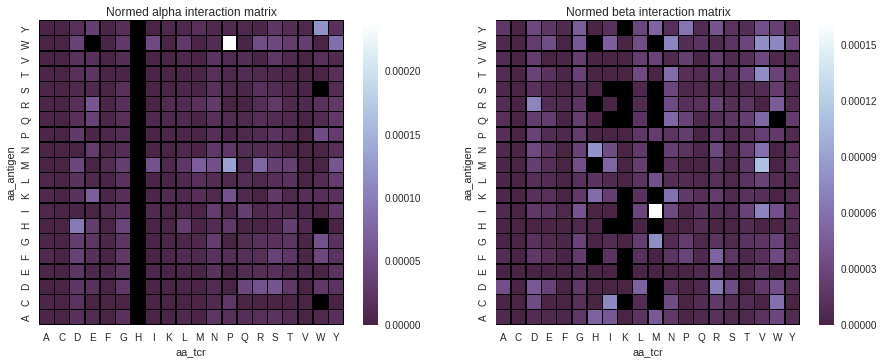

In [32]:
sns.set(rc={'axes.facecolor':'black'})  
plt.figure(figsize=(15,12))

plt.subplot(221)
heatmap(aa_interaction_matrix_unnormed(ser_all_alpha) / get_norming_matrix_1(ser_all_alpha))
plt.title('Normed alpha interaction matrix')

plt.subplot(222)
heatmap(aa_interaction_matrix_unnormed(ser_all_beta) / get_norming_matrix_1(ser_all_beta))
plt.title('Normed beta interaction matrix')

sns.set(rc={'axes.facecolor':'white'})

### Number of contacting amino acids for each complex


Here histograms showing the distribution of the number of contacts of amino acid presented in the CDR3 region and the antigen for each complex are provided. For each complex the number of contacs for alpha and beta chains separately is collected using different distance thresholds. Blue line on each histogram corresponds to the mean number of contacts over all the complexes.
- - -

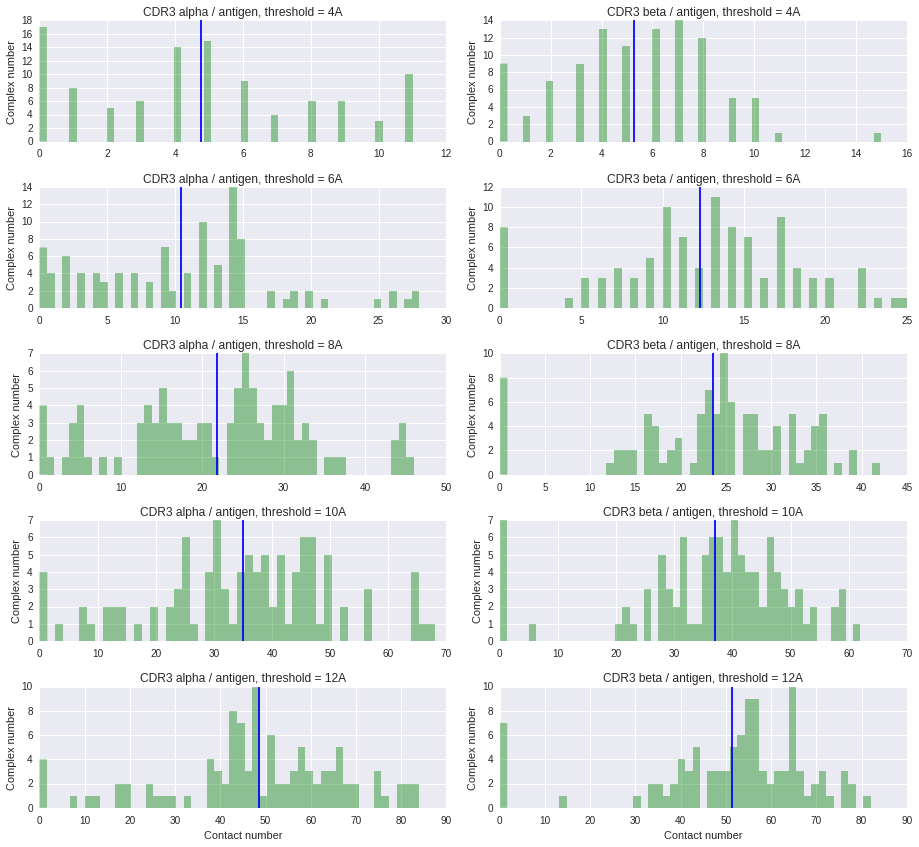

In [225]:
# list of number of contacts for each complex for particular threshold
def get_contact_list(grouped, threshold=DISTANCE_THRESHOLD):
    return [(grouped.get_group(name)['distance'] < threshold).sum() for name in pnames]

# wrapper
def plot_contact_hist(x):
    sns.distplot(x, bins=50, norm_hist=False, kde=False, color='green')
    plt.axvline(x.mean())
    plt.ylabel("Complex number")

# plot settings
sns.set_style('darkgrid')
plt.figure(figsize=(13, 12))
dist_thresh_list = range(4, 13)[::2]

# plotting alpha hists
for i in dist_thresh_list:
    plt.subplot(5, 2, i - 3)
    x = np.array(get_contact_list(grouped_alpha, i))
    plot_contact_hist(x)
    plt.title("CDR3 alpha / antigen, threshold = " + str(i) + "A")
plt.xlabel("Contact number")

# plotting beta
for i in dist_thresh_list:
    plt.subplot(5, 2, i - 2)
    x = np.array(get_contact_list(grouped_beta, i))
    plot_contact_hist(x)
    plt.title("CDR3 beta / antigen, threshold = " + str(i) + "A")
    
plt.xlabel("Contact number")
plt.tight_layout()

Here the correlation between the number of contacts in the alpha chain and the number of contacts in the beta chain for each complex is presented. Again graphs are built for different distance thresholds.
- - -

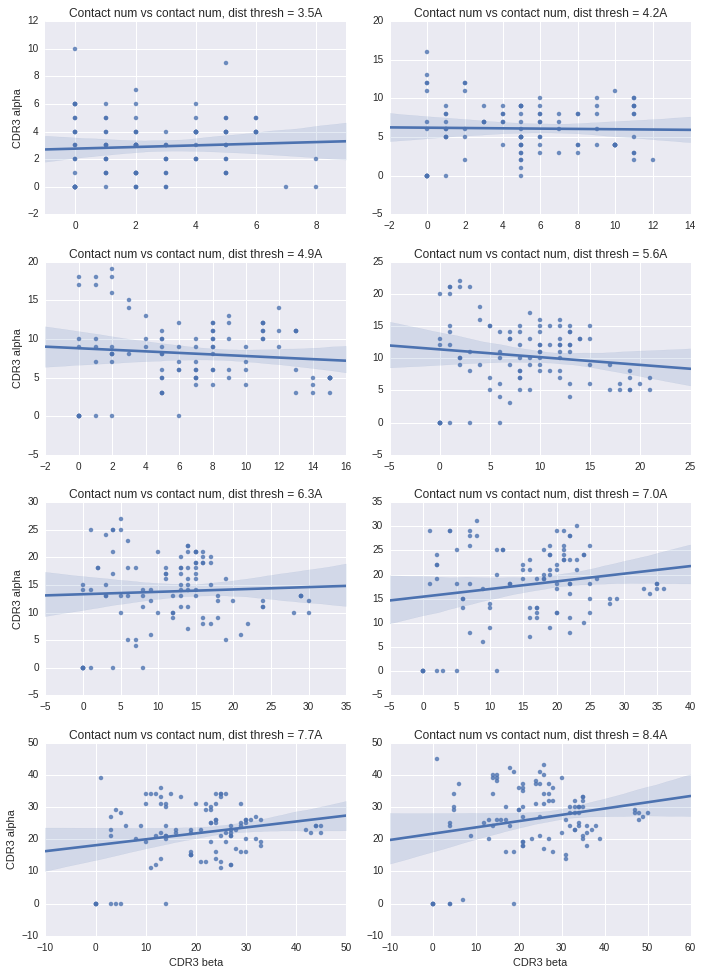

In [248]:
# Alpha/Beta contact number correlation
def draw_graph(x, y, thresh):
    sns.regplot(x, y)
    plt.title("Contact num vs contact num, dist thresh = " + str(thresh) + "A")

# Range of distance thresholds
dist_thresh_list = np.arange(3.5, 9., .7)#range(4, 15)[::2]
plt.figure(figsize=(10, 20))

# Plotting
sns.set_style('darkgrid')

plot_id = -1
for thresh in dist_thresh_list[::2]:
    
    plot_id += 2
    plt.subplot(6, 2, plot_id)
    alpha_contact_nums = get_contact_list(grouped_alpha, thresh)
    beta_contact_nums = get_contact_list(grouped_beta, thresh)
    draw_graph(np.array(alpha_contact_nums), np.array(beta_contact_nums), thresh)
    plt.ylabel("CDR3 alpha")
plt.xlabel("CDR3 beta")
    
plot_id = 0
for thresh in dist_thresh_list[1::2]:
    plot_id += 2
    plt.subplot(6, 2, plot_id)
    alpha_contact_nums = get_contact_list(grouped_alpha, thresh)
    beta_contact_nums = get_contact_list(grouped_beta, thresh)
    draw_graph(np.array(alpha_contact_nums), np.array(beta_contact_nums), thresh)
plt.xlabel("CDR3 beta")
plt.tight_layout()

